# Week 10 Monday

## Announcements

* Midterms will be returned at the end of this week.
* Two worksheets due tonight.
* No more quizzes or exams.  After tonight's worksheets, your main responsibility is to complete the course project.
* Plan for Wednesday: some time to work on project, most of the class an introduction to programming using ChatGPT (or actually Bing chat).


In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

## The numbers in the decision tree diagram

The file `cleaned_temperature.csv` contains the data we finished with on Wednesday.  (So we've already melted the data, removed rows with missing values, restricted the result to three cities, added indicator columns for the cities, and added numerical columns related to the datetime value.)

* Load the attached csv file and keep only the first 20000 rows (to speed up the `fit` step below).

In [2]:
df = pd.read_csv("cleaned_temperature.csv")[:20000]

* Plot the data from rows 6400 to 7000 using the following code.
```
alt.Chart(df[6400:7000]).mark_line().encode(
    x="datetime",
    y="temperature",
    color="city",
    tooltip=["city", "temperature", "datetime"]
).properties(
    width=600
)
```
* Use a `format` keyword argument to an Altair Axis object ([documentation](https://altair-viz.github.io/user_guide/generated/core/altair.Axis.html)) so that we see the day of the week in the chart.

Notice how bad the x-axis looks.  Something has clearly "gone wrong".

In [3]:
alt.Chart(df[6400:7000]).mark_line().encode(
    x="datetime",
    y="temperature",
    color="city",
    tooltip=["city", "temperature", "datetime"]
).properties(
    width=600
)

alt.Chart(...)

The problem is that we forgot to use the `parse_dates` keyword argument.  (Another option would be to use `pd.to_datetime`... that's what we mostly did in the first half of Math 10.)

In [4]:
df = pd.read_csv("cleaned_temperature.csv", parse_dates=["datetime"])[:20000]

Notice how much better the x-axis looks.  We also use an Altair Axis object and the `format` keyword argument to specify that the day of the week name should be given along the axis.  (See the `format` portion of the above documentation link.)  We use `"%A"` to get the weekday name.

In [6]:
alt.Chart(df[6400:7000]).mark_line().encode(
    x=alt.X("datetime", axis=alt.Axis(format="%A")),
    y="temperature",
    color="city",
    tooltip=["city", "temperature", "datetime"]
).properties(
    width=600
)

alt.Chart(...)

As another example (again, this is based on following the above documentation link), here we use the short form of the day name ("Sat" instead of "Saturday", because we used "%a" instead of "%A"), and also list the hour and whether it is AM or PM.

In [8]:
alt.Chart(df[6400:7000]).mark_line().encode(
    x=alt.X("datetime", axis=alt.Axis(format="%a %I %p")),
    y="temperature",
    color="city",
    tooltip=["city", "temperature", "datetime"]
).properties(
    width=600
)

alt.Chart(...)

We will fit our decision tree using the following predictor columns.

In [9]:
var_cols = ["year", "day", "month", "hour", "day_of_week"]
city_cols = [c for c in df.columns if c.startswith("city_")]
cols = var_cols+city_cols

Here are the eight input variables we will use.

In [10]:
cols

['year',
 'day',
 'month',
 'hour',
 'day_of_week',
 'city_Detroit',
 'city_San Diego',
 'city_San Francisco']

* Instantiate a `DecisionTreeRegressor` object specifying `10` for the maximum number of leaf nodes.
* Instead of using the default Mean Squared Error (MSE) criterion, specify the Mean Absolute Error (MAE) criterion.

Be sure you're using a `DecisionTreeRegressor`, and not a `DecisionTreeClassifier`.  We are trying to predict temperatures, which is a quantitative value, not a discrete value.  That's why this is a regression task.

In [11]:
from sklearn.tree import DecisionTreeRegressor

Just for the fun of it, or to see an alternative, we specify that we want to use a non-default metric.  We are going to use Mean Absolute Error instead of the default Mean Squared Error.

In [12]:
tree = DecisionTreeRegressor(max_leaf_nodes=10, criterion="absolute_error")

* Fit the decision tree.  (Even with only 20,000 rows and 10 leaf nodes, this seems quite a bit slower than using MSE.  It took about 30 seconds when I tried.  I couldn't get it to work at all using the full 100,000 row dataset.)

In [13]:
tree.fit(df[cols], df["temperature"])

DecisionTreeRegressor(criterion='absolute_error', max_leaf_nodes=10)

* Make the corresponding decision tree diagram using the following code.
```
fig = plt.figure(figsize=(20,10))
_ = plot_tree(tree, 
                   feature_names=tree.feature_names_in_,
                   filled=False)
```

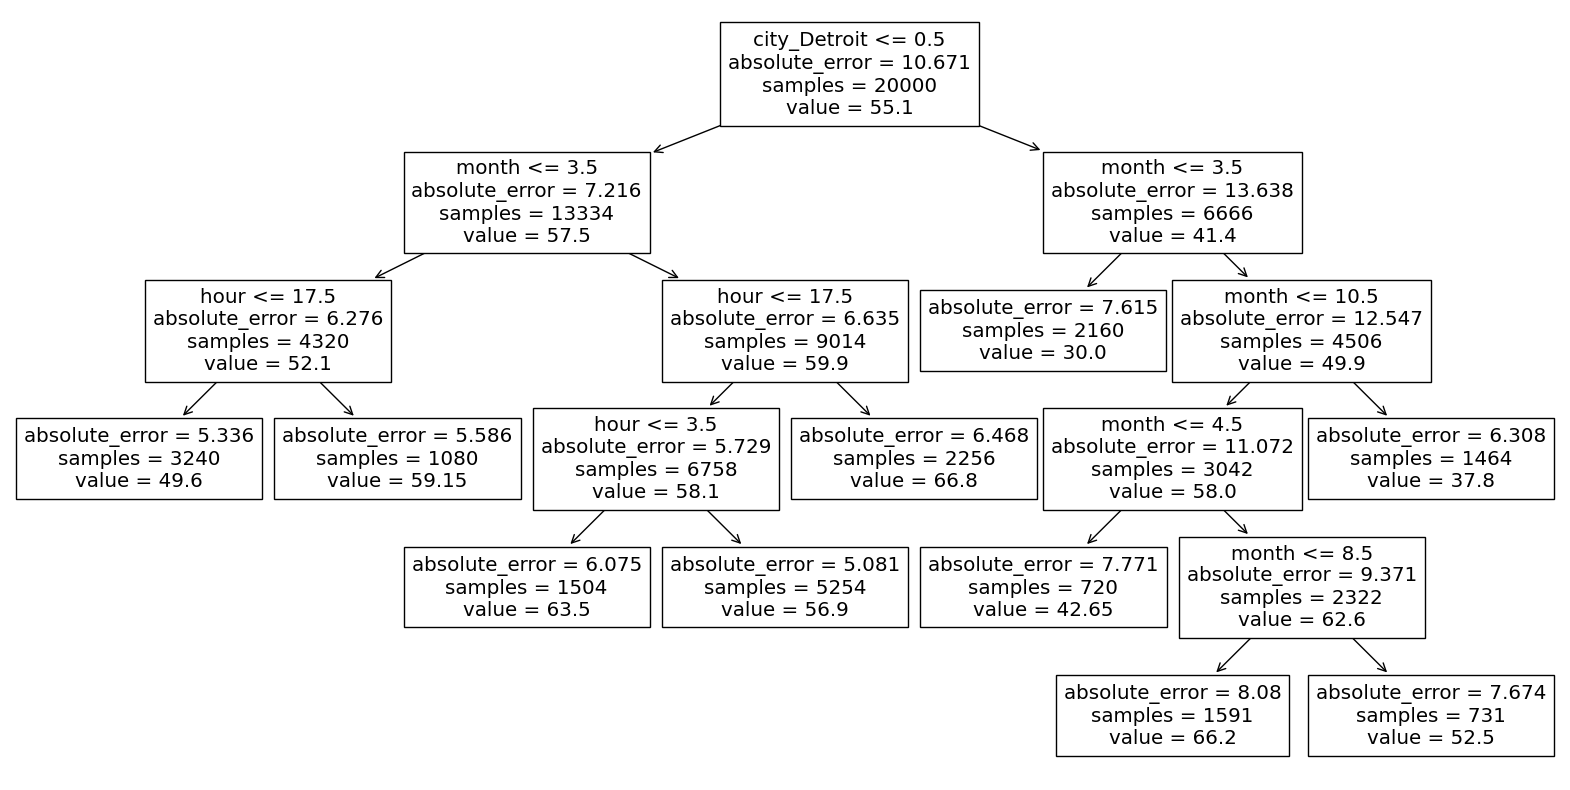

In [14]:
fig = plt.figure(figsize=(20,10))
_ = plot_tree(tree, 
                   feature_names=tree.feature_names_in_,
                   filled=False)

We are going to focus on one particular leaf node towards the middle left: the one with absolute error `5.586` and with `1080` samples.  You should locate that node on the mid-left side of the diagram, because we will refer to it numerous times below.

* Using Boolean indexing, can you identify what the values in one of the leaf nodes represent?

Our very first branch in the decision tree is to take the left-hand branch corresponding to `city_Detroit <= 0.5`.  This is like saying `city_Detroit == 0`, which is like saying `city_Detroit == False`, which is like saying the city is not Detroit.  That is the basis for our first Boolean Series `ser1` in the following definition.

In [16]:
ser1 = df["city"] != "Detroit"
ser1

0         True
1         True
2        False
3        False
4         True
         ...  
19995     True
19996    False
19997     True
19998     True
19999     True
Name: city, Length: 20000, dtype: bool

The next branch corresponds to `month <= 3.5`.  The next branch is a little different.  It corresponds to traveling to the right from the split `hour <= 17.5`.  Because we are traveling to the right rather than the left, we are in the portion of the data for which `hour > 17.5`.  That is why we set `ser3 = df["hour"] > 17.5`.

In [17]:
ser2 = df["month"] <= 3.5
ser3 = df["hour"] > 17.5

We want the portion of the data where all three conditions hold.  So we combine these Boolean Series together using `&`.  We set `df_sub` to be the rows from `df` for which these three conditions are all satisfied.  Here we are using Boolean indexing.

In [18]:
df_sub = df[ser1 & ser2 & ser3]

Notice that the rows in `df_sub` are indeed not from Detroit, from a month January through March, and from an hour later than 5pm.

In [19]:
df_sub.head(4)

,datetime,temperature,city_Detroit,city_San Diego,city_San Francisco,city,day,month,year,hour,day_of_week
6639,2013-01-01 18:00:00,47.3,0,0,1,San Francisco,1,1,2013,18,1
6641,2013-01-01 18:00:00,51.2,0,1,0,San Diego,1,1,2013,18,1
6642,2013-01-01 19:00:00,48.6,0,0,1,San Francisco,1,1,2013,19,1
6644,2013-01-01 19:00:00,54.8,0,1,0,San Diego,1,1,2013,19,1


Look back at the leaf node in our tree diagram.  We are ready to see what one of the values there represents.  The `samples = 1080` corresponds to how many data points are in our region of the data, or equivalently, how many rows are in `df_sub`.  Indeed, we check that `df_sub` has 1080 rows.

In [20]:
df_sub.shape

(1080, 11)

What about the value `59.15`, which is the number our decision tree will predict for any input in our region?  I would have expected it to be the average of the values for our 1080 data points, but it's not.

In [21]:
df_sub["temperature"].mean()

59.63074074074074

Instead, because we set `criterion="absolute_error"`, scikit-learn automatically uses the median instead of the mean.  In general, you should think that Mean Absolute Error and median are less dependent on outliers, and that Mean Squared Error and mean are more dependent on outliers.  As a simple example involving mean vs median.  The mean of `[70, 70, 74, 80, 10**100]` will be huge, roughly $10^{99}$, but the median of `[70, 70, 74, 80, 10**100]` will simply be `74`; the outlier value had no influence on our median calculation.

Back to the value `59.15` shown in the leaf node, that is the indeed the median of the 1080 values in our sub-DataFrame.

In [22]:
df_sub["temperature"].median()

59.150000000000006

Lastly, let's see where the `absolute_error = 5.586` comes from.  We could compute MAE on our own, but let's go ahead and import the relevant function from `sklearn.metrics`.

In [23]:
from sklearn.metrics import mean_absolute_error

We aren't allowed to compare with a float directly.

In [24]:
mean_absolute_error(df_sub["temperature"], 59.15)

TypeError: Expected sequence or array-like, got <class 'float'>

Just to see a new NumPy function, here is an example of how `np.full_like` works.  The following puts three copies of `59.15` into a NumPy array (because our first argument had three elements).

(I didn't notice this during class, but it looks like they also get rounded to integers, presumably because our first argument has integers.)

In [26]:
np.full_like([1,3,5], 59.15)

array([59, 59, 59])

Here is a fancy way to get the correct number of `59.15` values in a NumPy array.  This can be compared to `df_sub["temperature"]` using `mean_absolute_error`.

In [28]:
y_pred = np.full_like(df_sub["temperature"], 59.15)
y_pred

array([59.15, 59.15, 59.15, ..., 59.15, 59.15, 59.15])

Notice that this `y_pred` does indeed have the correct number of entries.  We are calling it `y_pred` because these are the predictions that our decision tree will make for every input in `df_sub`.  (Each leaf node has a single output.  For this particular leaf node, the output is `59.15`.)

In [29]:
len(y_pred)

1080

Now we can finally reproduce the number `5.586` from the tree diagram.

In [30]:
mean_absolute_error(df_sub["temperature"], y_pred)

5.586111111111111

Notice that our array `y_pred` does indeed match the predicted values for our sub-DataFrame.

In [31]:
tree.predict(df_sub[cols])

array([59.15, 59.15, 59.15, ..., 59.15, 59.15, 59.15])

We didn't get further than this.  I don't think we will continue with this on Wednesday; instead we'll see an example of using Bing Chat for programming.

## Inadequacy of `train_test_split`

I don't think we will get this far today.

* Load the full dataset.

* Divide the data using `train_test_split`, using 80% of the rows for the training set.

* Instantiate a new decision tree, this time using the default criterion choice (MSE) and allowing a maximum of 1000 leaf nodes.

* Fit the data.  (What set should we use?)

* What is the Mean Squared Error for our predictions on the training set?  On the test set?